This is just a quick post to show off [DataDeps.jl](https://github.com/oxinabox/DataDeps.jl/).
DataDeps.jl is the long discussed BinDeps for data.
At it's heart it is a tool for reproducible data science.
It means anyone trying to run your code later, in a different environment isn't faffing around trying to work out where to download the data from and how to connect it to your scripts.
<!--more-->

I am not going to go into too much detail here, It is all documented in the package README.
Like most of my blog-posts this is available as  [Jupyter Notebook on my Github]().

## Example 1: Word Embeddings, data for your model

Your system might need word embeddings.
They are pretty important for a lot of NLP research.
If you want to use pretrained ones, they can be pretty big though.
Too big for adding to your repository.
They are definitely data that your model depends on.

In [1]:
using DataDeps, Plots

First we are going to register a DataDep.
In a package this would go in your modules `__init__` function.
We are going to declare a data dependency for some word embeddings.

In [ ]:
RegisterDataDep("FastText en",
    """
    Dataset: FastText Word Embeddings for English.
    Author: Bojanowski et. al. (Facebook)
    License: CC-SA 3.0
    Website: https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md
    
    300 dimentional FastText word embeddings, trained on Wikipedia
    Citation: P. Bojanowski*, E. Grave*, A. Joulin, T. Mikolov, Enriching Word Vectors with Subword Information

    Notice: this file is over 6.2GB
    """,
    "https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec",
);

Let's see what we've got.
Rather than needing to refer to your data by a path on disk, DataDeps.jl allows you to refer to it by name
with a datadep string macro.
This resolves into a path to it on disk -- even if that mean downloading it first.

In [ ]:
readdir(datadep"FastText en")

Now we are going to define a function to load up those word embeddings.
DataDeps.jl doesn't handle loading data -- just downloading data.
To load the data would require understanding a lot about its format.
That is left to the user, or to other packages like [MLDatasets.jl](https://github.com/JuliaML/MLDatasets.jl)
that know what the data they are consuming is.

Notice here the use of `filepath=datadep"FastText en/wiki.en.vec"` as an optional argument.
This is a common pattern that I recommend using with DataDeps.jl.
It means if the user provides a path, the datadep string is never evaluated.
Which in turn means the data download will not be triggered (though in this case it has already been).

In [ ]:
function word_embeddings(load_words, filepath=datadep"FastText en/wiki.en.vec")
    embs = Dict{String, Vector{Float32}}()
    
    load_words.*=" " #add as space so that we can use startswith to check
    for line in Iterators.drop(eachline(filepath), 1) # skip header on the first line
        if any(startswith.(line, load_words))
            toks = split(line)
            word = first(toks)
            embs[word] = parse.(toks[2:end])
        end
    end
    embs
end

In [ ]:

# Note: these categories are not mutually exclusive
# orange is a food and a color etc
# I've broken categories arbitrarily

foods = split("turkey chicken duck apple banana cheese sausage milk egg")
sports = split("cricket golf baseball football soccer rugby run walk swim dive")
colors = split("orange yellow blue green red")
tools = split("tape glue nails hammer saw drill")
objects = split("phone car truck record shed house castle rook")
other = split("down up wood danger risk reward  new old fresh stale glass stone china face");

In [ ]:
# A bit of a metaprogramming hack
category_lookup = Dict{String,Symbol}()
for cat in [:foods, :sports, :colors, :tools, :objects, :other]
    var = eval(cat)
    for word in var
        category_lookup[word] = cat
    end
end
category_lookup;

In [ ]:
embs_dict = word_embeddings(keys(category_lookup))

Let's visualise them.
Had to do a bit of hacking around with Plots.jl to get the visualisation I want.
Color according to category, text according to index

In [ ]:
index = collect(keys(embs_dict))
embs = hcat(values(embs_dict)...)
categories = getindex.(category_lookup, index)
using Plots
using TSne # Note this package is not registered, you'll have to clone it
embs_dr = tsne(Float64.(embs)', 2, 0, 1000, 10.0)' # TSne.jl is still sideways, still only works with Float64s


## Plot it
function groupup(data::T, groupby=data) where {T}
    group_ind = Dict(reverse.(collect(enumerate(unique(groupby)))))
    ret = [eltype(T)[] for _ in 1:length(group_ind)]
    for (datum,group) in zip(data,groupby)
        push!(ret[group_ind[group]], datum)
    end
    ret
end


xss = groupup(embs_dr[1,:],categories)
yss = groupup(embs_dr[2,:],categories)
textss = groupup(index, categories)
plot(); #clear the ploat
for (xs, ys, texts) in zip(xss, yss,textss)
    scatter!(xs, ys, series_annotations= texts, alpha=0.4)
end
plot!(legend=false)

That worked pretty well, I think tweaking the perplexity on TSNe a bit more could get better result.
Of course as with all dimentionality reduction some information is going to be lost and not expressed in the final form.
Sill I think it has done well, the FastText embeddings are pretty good.
Notice that it has located turkey and china together, pressumably because their embeddings reflect that they are  countries.
FastText actually doesn't capture countries during training as far as I can tell, I believe they attempt to remove all proper nouns during preprocessing (E.g. England is not in their), but I guess China and Turkey slip through as they are also regular nouns.
Notice also that the ball-sports are located together, separately from movement types like swim, walk and run.
New is near Fresh and old is near stale.

## Example 2: WordNet.jl: Data for your package

I love [WordNet.jl](https://github.com/JuliaText/WordNet.jl).
WordNet is a pretty fundermental tool for NLP research (though it is getting a bit dated).
WordNet.jl is the julia binding.
Understandably, @jbn doesn't want to include the WordNet database in the repository.
Because of concerns about the filesize, and about redistributing someone elses work.
However, it is fully dependent on having that data.
So by not automatically installing that it makes it hard to build anything on top of it.
Now this could be done with BinDeps for example or just by sticking a `download` into `/deps/build.jl`,
but that isn't great for this.
There is no chance to display a message about the data's real owner,
and the location of the data wouldn't be flexible -- a path would need to be hardcoded in.

DataDeps.jl expressly designed for these concerns.
(IDk if @jbn will agree, I'll make a PR some time and find out)

What do we have to do to get WordNet.jl working without any manual data configuration by the user?

In [ ]:
using WordNet, DataDeps

In [ ]:
RegisterDataDep("WordNet 3.0",
    """
    Dataset: WordNet 3.0
    Website: https://wordnet.princeton.edu/wordnet

    George A. Miller (1995). WordNet: A Lexical Database for English.
    Communications of the ACM Vol. 38, No. 11: 39-41.

    Christiane Fellbaum (1998, ed.) WordNet: An Electronic Lexical Database. Cambridge, MA: MIT Press.

    License: 
    WordNet Release 3.0 This software and database is being provided to you, the LICENSEE, by Princeton University under the following license. By obtaining, using and/or copying this software and database, you agree that you have read, understood, and will comply with these terms and conditions.: Permission to use, copy, modify and distribute this software and database and its documentation for any purpose and without fee or royalty is hereby granted, provided that you agree to comply with the following copyright notice and statements, including the disclaimer, and that the same appear on ALL copies of the software, database and documentation, including modifications that you make for internal use or for distribution. WordNet 3.0 Copyright 2006 by Princeton University. All rights reserved. THIS SOFTWARE AND DATABASE IS PROVIDED "AS IS" AND PRINCETON UNIVERSITY MAKES NO REPRESENTATIONS OR WARRANTIES, EXPRESS OR IMPLIED. BY WAY OF EXAMPLE, BUT NOT LIMITATION, PRINCETON UNIVERSITY MAKES NO REPRESENTATIONS OR WARRANTIES OF MERCHANT- ABILITY OR FITNESS FOR ANY PARTICULAR PURPOSE OR THAT THE USE OF THE LICENSED SOFTWARE, DATABASE OR DOCUMENTATION WILL NOT INFRINGE ANY THIRD PARTY PATENTS, COPYRIGHTS, TRADEMARKS OR OTHER RIGHTS. The name of Princeton University or Princeton may not be used in advertising or publicity pertaining to distribution of the software and/or database. Title to copyright in this software, database and any associated documentation shall at all times remain with Princeton University and LICENSEE agrees to preserve same.
    """,
    "http://wordnetcode.princeton.edu/3.0/WNdb-3.0.tar.gz",
    "658b1ba191f5f98c2e9bae3e25c186013158f30ef779f191d2a44e5d25046dc8";
    post_fetch_method = unpack
);

In [ ]:
WordNet.DB() = DB(datadep"WordNet 3.0")

That is it, that declaration of the datadep via the registration block (Mostly just copy-pasted),
and the addition of a method to the DB constructor,
and we are done.

In [ ]:
db = DB()
lemma = db['n', "turkey"]

In [ ]:
ss = synsets(db, lemma)

In [ ]:
expanded_hypernyms(db, ss[2])

## Example 3: 538: Aveneger's Comic Book Characters:  DataDepsGenerators.jl

So this last example is a change to show off [DataDepsGenerators.jl](https://github.com/oxinabox/DataDepsGenerators.jl).
It does the kinda fragile webscraping to generate code for registration blocks, which you can then edit and include into your project that uses DataDeps.jl.

We are going to load-up 538's dataset on Marvel Comic book characters.    

In [3]:
using DataDeps, DataDepsGenerators

In [10]:
generate(GitHub(), "https://github.com/fivethirtyeight/data/tree/master/avengers") |> print

RegisterDataDep(
    "fivethirtyeight  data",
    """
	Dataset: fivethirtyeight / data
	Website: https://github.com/fivethirtyeight/data/tree/master/avengers
	### Avengers
	
	This directory contains the data behind the story [Joining The Avengers Is As Deadly As Jumping Off A Four-Story Building](http://fivethirtyeight.com/features/avengers-death-comics-age-of-ultron).
	
	It includes the dataset `avengers.csv`, which details the deaths of Marvel comic book characters between the time they joined the Avengers and April 30, 2015, the week before Secret Wars #1.
	
	Header | Definition
	---|---------
	`URL`| The URL of the comic character on the Marvel Wikia
	`Name/Alias` | The full name or alias of the character
	`Appearances` | The number of comic books that character appeared in as of April 30 
	`Current?` | Is the member currently active on an avengers affiliated team?
	`Gender` | The recorded gender of the character
	`Probationary` | Sometimes the character was given probationary stat

Now DataDepsGenerators.jl isn't perfect, you do have to check it by hand, and probably edit it a bit.
For example because of how 538 laid out their github repo (see issue [fivethirtyeight/data/#101](https://github.com/fivethirtyeight/data/issues/101), DataDepsGenerators thinks this data is MIT lisenced.
It is actually Creative Commons Attribution 4.0 International License.
We're in complaince with that notice anyway, as it includes (I believe, but IANAL) all the attribution information we need.

Not also it has failed to give it a good datadep name.

You shouldn't do this in your packages, but for an demo like this, we can register that generated data dep immediately.
We'll pass in the name to the generator this time too.

In [4]:
eval(parse(generate(GitHub(), "https://github.com/fivethirtyeight/data/tree/master/avengers", "538 Avengers")));

Time to load it up, and then we will do some visualisations.

In [5]:
using FileIO, CSVFiles, DataFrames, Plots
characters = DataFrame(load(datadep"538 Avengers/avengers.csv"; escapechar='"'));

Lets see what the distribution of how frequently characters the characters appear appear is:


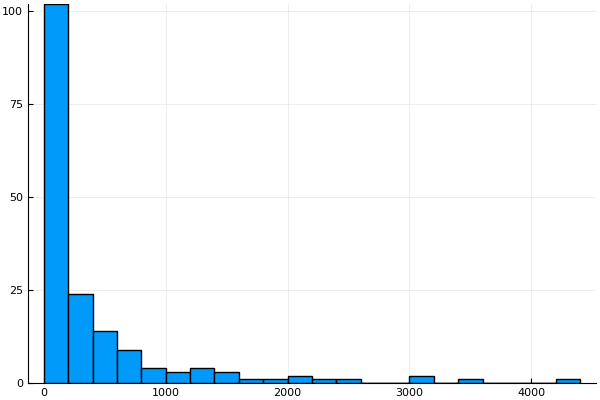

In [117]:
histogram(characters[:Appearances], legend=false)

Looks kinda Ziphian. Not surprising.
So who are the heavy hitters?

In [119]:
sort!(characters, cols = [:Appearances], rev=true);
println.(characters[Symbol("Name/Alias")][1:5]);

Peter Benjamin Parker
Steven Rogers
James ""Logan"" Howlett
Anthony Edward ""Tony"" Stark
Thor Odinson


That's Spiderman, Captain America, Wolverine, Ironman and Thor.
Cool cool.
So that is a bunch of dudes.
How is the distribution of appreances is you separate out by gender:


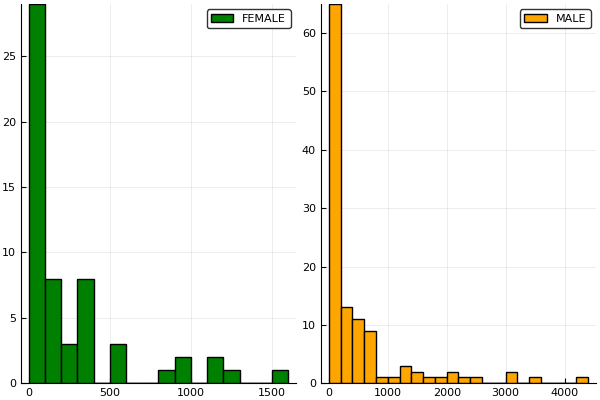

In [114]:
histogram(characters[:Appearances], group=characters[:Gender], nbins=20, layout=2, color=["GREEN" "ORANGE"])

In [63]:
ladies, dudes = groupby(characters, :Gender);
println("Number of characters (Ladies, Dudes)):\t\t", nrow.([ladies, dudes]))
println("Total appearances (Ladies, Dudes)):\t\t", sum.([ladies[:Appearances], dudes[:Appearances]]))
println("Median appearances (Ladies, Dudes)):\t\t", median.([ladies[:Appearances], dudes[:Appearances]]))

Number of characters (Ladies, Dudes)):		[58, 115]
Total appearances (Ladies, Dudes)):		[15273, 56358]
Median appearances (Ladies, Dudes)):		[101.0, 156.0]


Ok, well that tells a story. Note that the scale (vertical and horisontal) for the ladies plot is less than half that as for the dudes.

Lets see when characters were introduced, this is the year the characters join the avengers no the year they were first published (unfortunately). I suspect they correlate to some degree though.


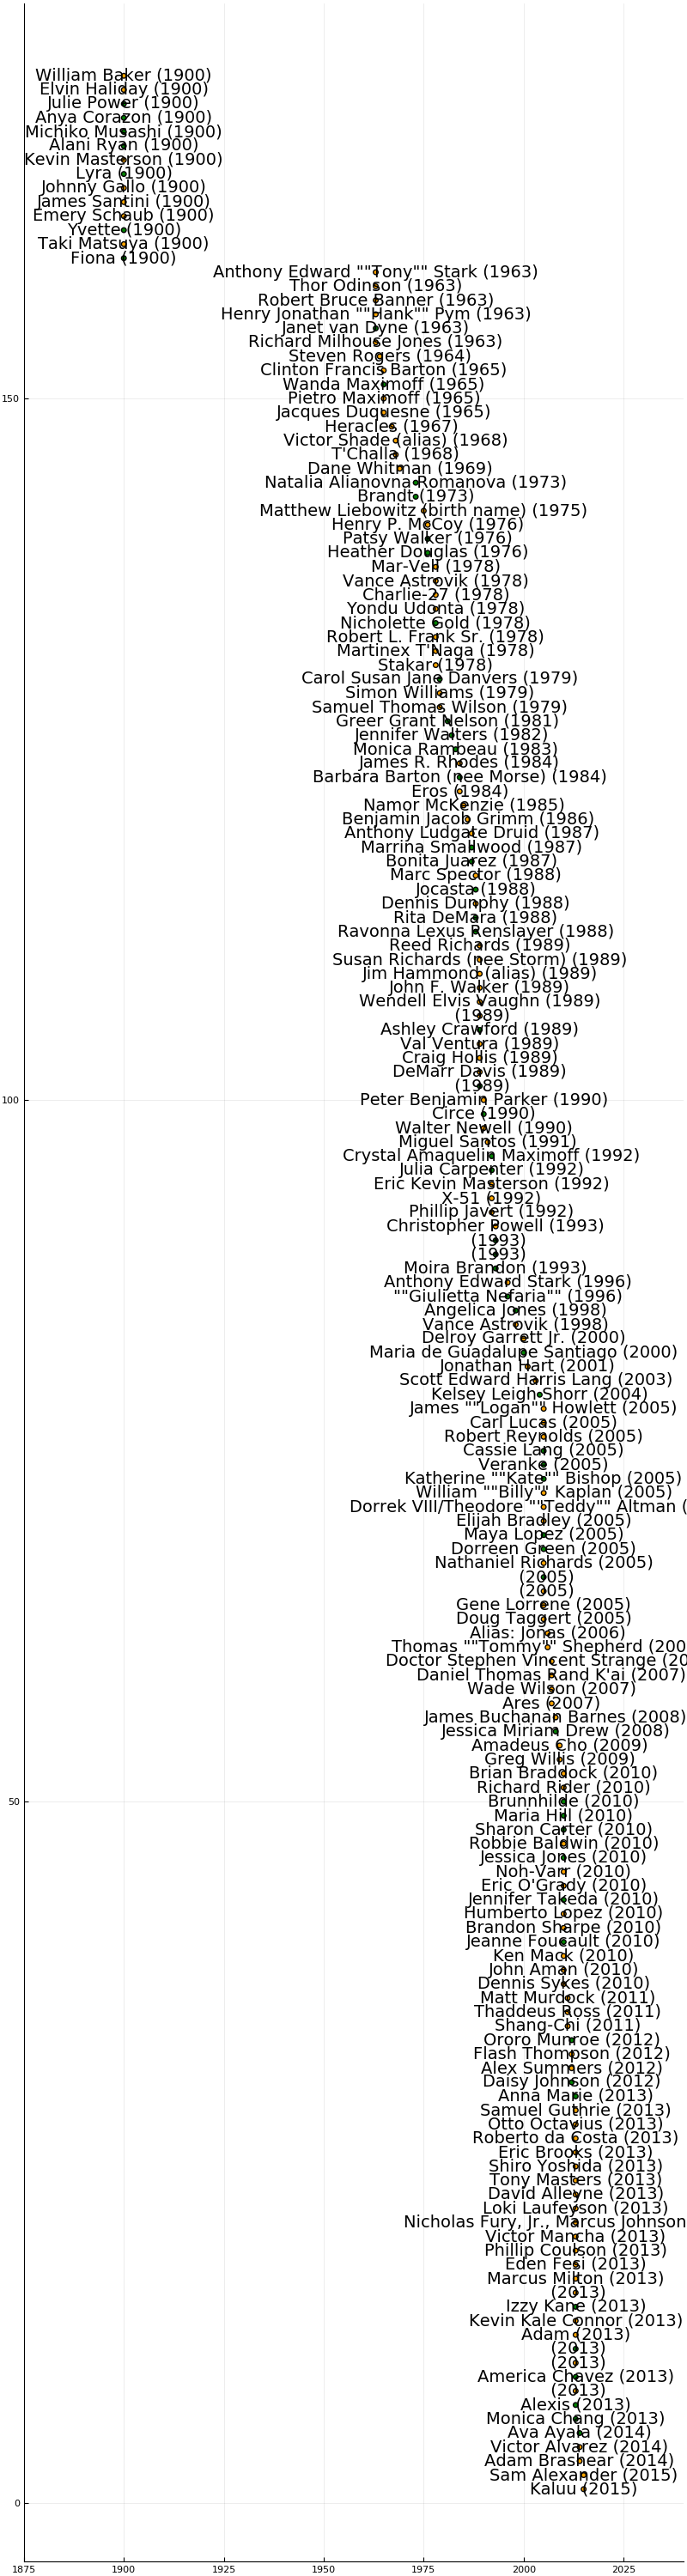

In [115]:
sort!(characters,cols=:Year)
scatter(characters[:Year],(173:-1:1); size=(800,3000), xlim=(1875,2040),legend=false,
    text=characters[Symbol("Name/Alias")].*" (" .* string.(characters[:Year]).*")",
    markercolor = ifelse.(characters[:Gender].=="MALE", "ORANGE", "GREEN")
)

Anyway that is enough about comic books.   
DataDeps.jl isn't about processing data, or the stuff I can do with it.  
It is about setting up data so you can do stuff with it

## Conclusion

DataDeps.jl: get on it.  
Sort out your data depenancies.  
Make your scientific code easier for other people reproduce run by having it automatically download it's data.  
Make your packages easier to install by removing manual steps.  
Spend less time worrying about setting up and managing your data,
and more time analysing it and advancing science. 